# LAB: quasi-Newton methods

Author : Alexandre Gramfort, Jair Montoya, Pierre Ablin

The objective of this lab session is to implement:
- Newton method
- DFP
- BFGS
- L-BFGS

And to investigate their behaviors.

You will need to use **line search methods**.

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work as jupyter notebook one week after the lab on the **moodle platform**.
- This means that **each student in the pair sends the same file**.
- The **name of the file must be** constructed as in the next cell.

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [2]:
# Change here using YOUR first and last names
fn1 = "nicolas"
ln1 = "saint"
fn2 = "matthis"
ln2 = "guérin"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["tp_newton", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

tp_newton_saint_nicolas_and_guérin_matthis.ipynb


# Part 0: Demo using Gradient descent

First import the necessary libraries:

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

%matplotlib inline

Now import the necessary function from the optim_utils.py file.

In [7]:
from optim_utils import test_solver

You'll only need the `test_solver` function.

This function expects a function as parameter.

The signature of the function `optimizer` to pass should be the following:

`optimizer(x0, f, f_grad, f_hessian)`

First, an example with a gradient descent.

In [8]:
def gradient_descent(x0, f, f_grad, f_hessian=None):

    default_step = 0.01
    c1 = 0.0001
    c2 = 0.9
    max_iter = 200
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = [], []
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    for k in range(1, max_iter + 1):

        grad_x = f_grad(x)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              -grad_x, grad_x,
                                                              c1=c1, c2=c2)
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        x -= step * grad_x

        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break

    return np.array(all_x_k), np.array(all_f_k)

Now, call the `test_solver` function with this solver:


Running solver on case 1

Running solver on case 2

Running solver on case 3


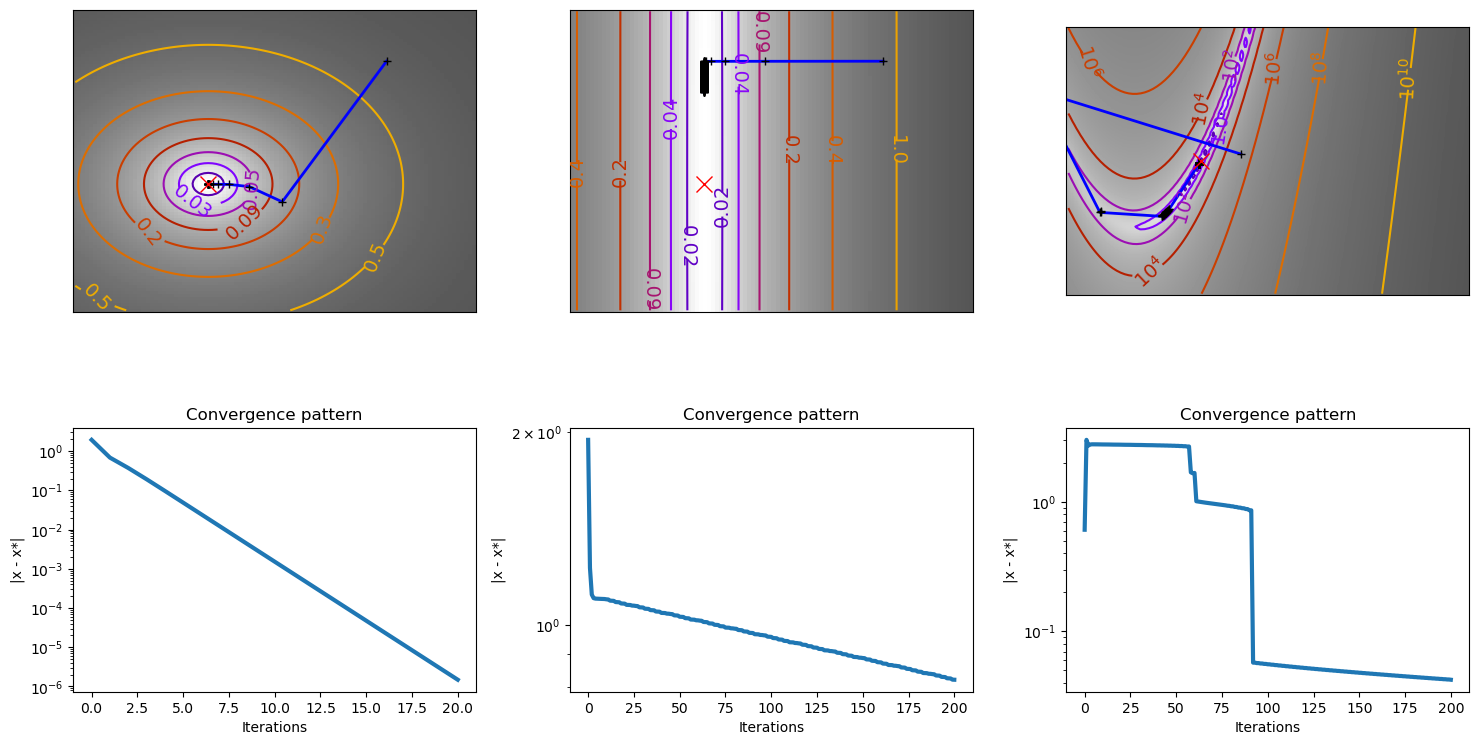

In [9]:
test_solver(gradient_descent)

It runs the algorithm on three functions:
- A non-convex Gaussian kernel ($f(x) = -\exp(-\|x\|^2)$)
- A badly conditioned quadratic function (but still strongly convex)
- The Rosenbrock function
    

# Part 1: Implement Newton method

<div class="alert alert-success">
    <b>QUESTION 1:</b>
     <ul>
         <li>Implement Newton's method. Beware that the Hessian SHOULD be regularized !</li>
         <li>Comment on what you observe. Do not describe the curves
             but rather comment if convergence rates match theoretical results.</li>
    </ul>
</div>

In [62]:
from scipy import linalg

def newton(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.00001
    c2 = 0.95
    max_iter = 100
    lambda_threshold = 0.0001 # regularization threshold

    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    for k in range(1, max_iter + 1):

        grad_x = f_grad(x)

        # Compute the Hessian, regularize it and compute the search direction d

        # Compute the Hessian
        hessian_matrix = f_hessian(x)

        # Regularize the Hessian
        min_eigenvalue = np.min(np.linalg.eigvals(hessian_matrix))
        if min_eigenvalue < lambda_threshold:
            hessian_matrix += (lambda_threshold - min_eigenvalue) * np.eye(len(hessian_matrix))

        # Compute the search direction d
        d = -linalg.solve(hessian_matrix, grad_x)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, _ = optimize.line_search(f, f_grad, x, d, grad_x, c1=c1, c2=c2)
        new_grad = f_grad(x)

        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        # Compute here the new value of x
        x += step * d

        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1

Running solver on case 2

Running solver on case 3


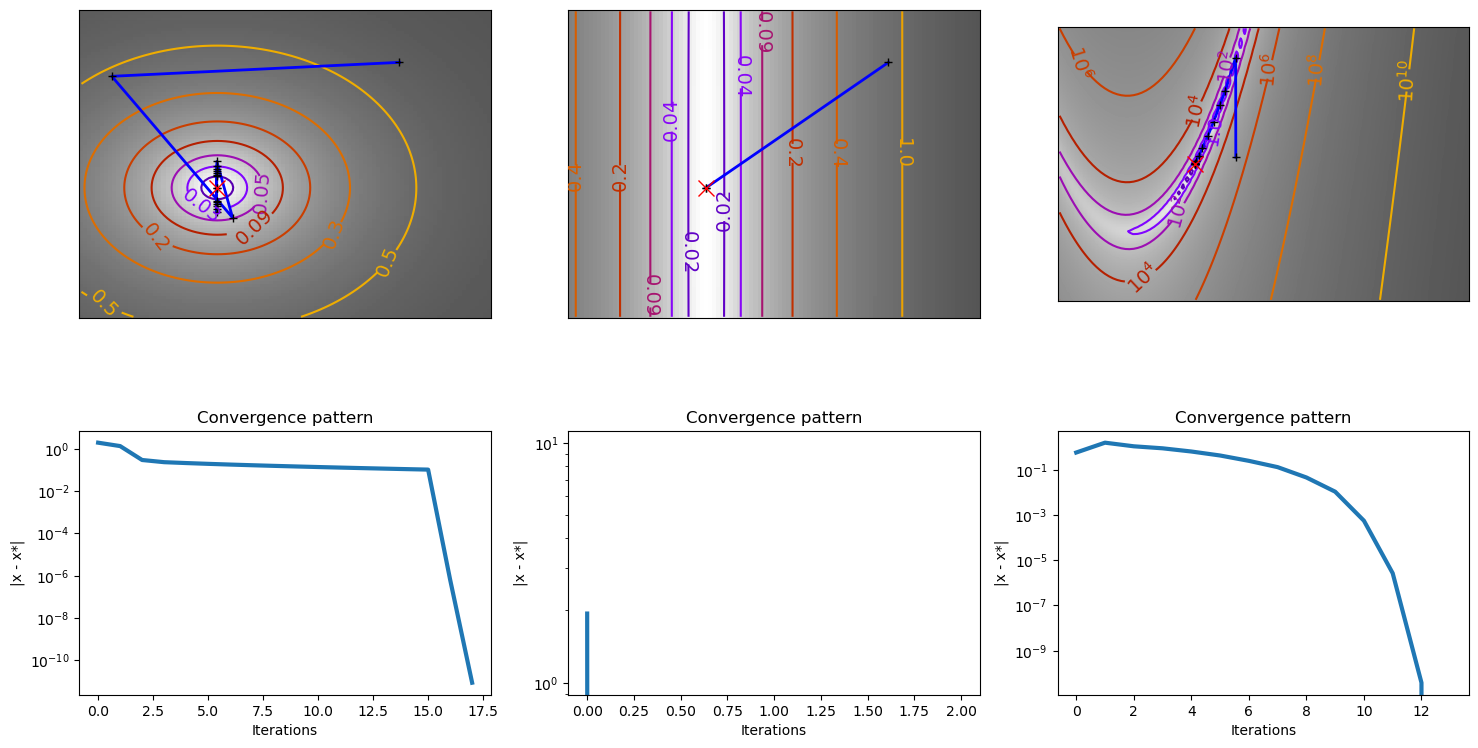

In [63]:
test_solver(newton)

**Anwser :**

The convergence patterns depicted should reflect the theoretical quadratic convergence rate of the Newton method, where the error $\|x_{k+1} - x^*\|$ is squared at each step, leading to a rapid decrease when approaching the solution. If the convergence is indeed quadratic, we would expect to see a steep decline in the plots.

To comment on whether the convergence rates match the theoretical results, we need to look for a consistent and rapid decline in the log-scale plots. For instance:

In a quadratic convergence, the slope of the convergence plot will be steeper and the decline more rapid, with the error decreasing by an order of magnitude or more with each iteration.
If the convergence doesn't match this pattern, such as if it plateaus or doesn't decrease exponentially, this may indicate that the convergence is slower than expected.

By analyzing the plots in the second image, we determine whether the experimental convergence rates match the theoretical quadratic convergence. In the first pattern log plot appear as straight lines that slope downward, this indicates a polynomial rate of convergence, with the steepness of the slope giving information about the rate. In the second patterns the plot shows a line that becomes horizontal, it show that the algorithm has reached a limit or is converging very slowly.

More over the convergence theorem for the Newton method states that, given certain regularity conditions (like a twice-differentiable function and an invertible derivative at the solution), the method will have quadratic convergence near an isolated root. This means the error will square at each iteration, leading to a rapid decrease sometihng that we observe in our plot.

# Part 2: Implement DFP algorithm

<div class="alert alert-success">
    <b>QUESTION 2:</b>
     <ul>
         <li>Now, implement the DFP algorithm using the formula for $B$ in the slides.</li>
         <li>Comment on what you observe. Focus on the explanation, not on describing the curves!</li>
         <li>Isn't there a contradiction on the quadratic functions with what we've seen in class? What is going on?</li>
    </ul>
</div>

In [18]:
def dfp(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.95
    max_iter = 200

    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    B = np.eye(len(x))  # inverse Hessian approximation, start from Id

    grad_x = f_grad(x)

    for k in range(1, max_iter + 1):

        # Compute the search direction
        d = np.dot(B, -grad_x)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)

        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        # Compute the new value of x
        s = step * d
        x = x + s
        y = new_grad - grad_x
        ################################################################
        # Update the inverse Hessian approximation

        B = B + np.outer(s, s) / np.dot(s, y) - np.outer(np.dot(B, y), np.dot(y, B)) / np.dot(y, np.dot(B, y))

        ################################################################

        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break

        grad_x = new_grad

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1

Running solver on case 2

Running solver on case 3


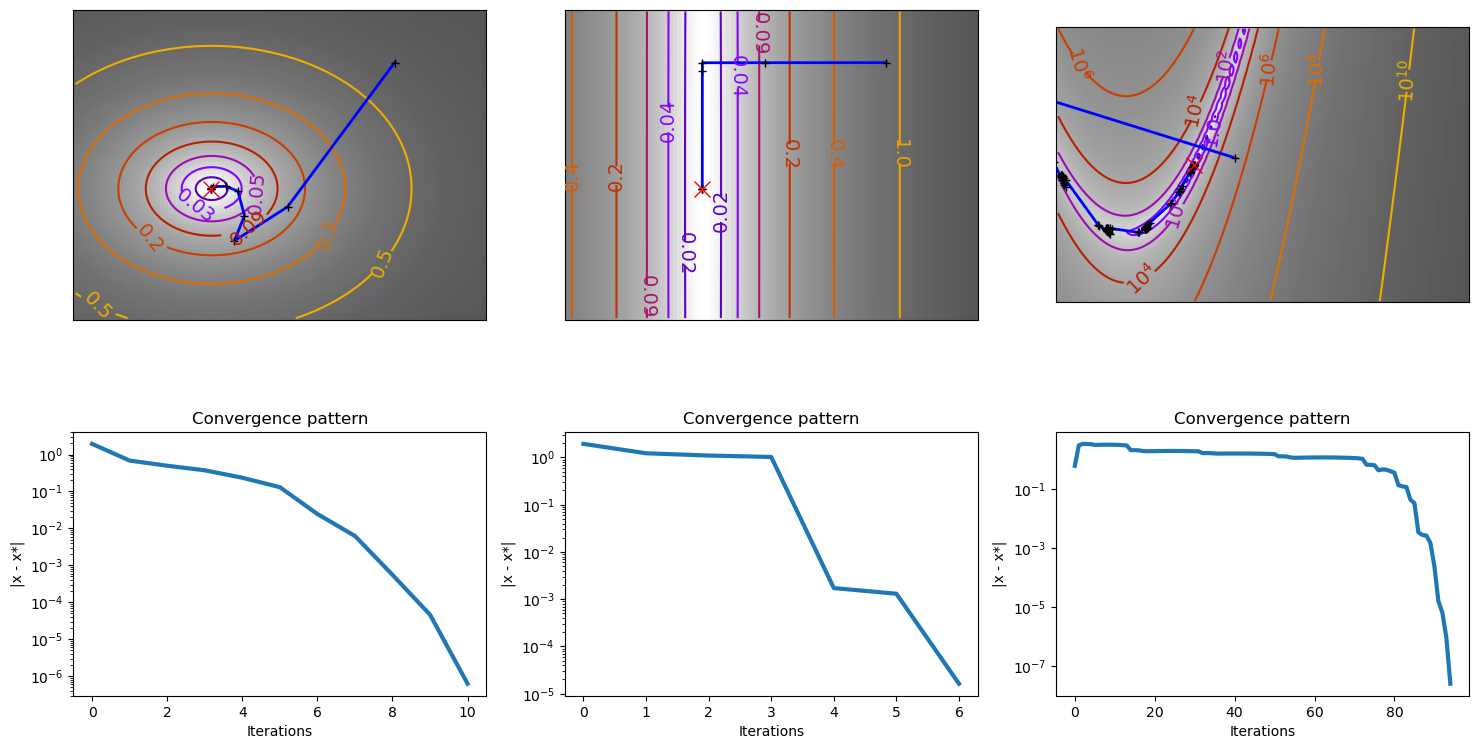

In [19]:
test_solver(dfp)

**Anwser :**

Let's consider the following points derived from the theorem and the algorithm's properties:

1. *Positive Definite of $( B_k )$: The update formula ensures the matrices $( B_k )$ remain positive definite. This implies that the directions chosen for moving towards the minimum are descent directions, which should result in continuous progress toward the minimum, visible in the trajectory plots.

2. Convergence in Quadratic Case: The theorem states that the DFP algorithm converges in at most \( n \) iterations for quadratic functions. This is because it effectively constructs the inverse Hessian matrix, confirm with the plot of the error should show a rapid decrease and possibly terminate within \( n \) steps.

3. Convergence Plot Expectations: Given the quadratic convergence in the ideal case, the convergence plot should display a steep and consistent decline in the error term, with the convergence being achieved within a few iterations.

Now, let's analyze the plots:

- Trajectory Plot: For a quadratic function, the paths should directly converge to the minimum, potentially showing a pattern of 'straight' moves if the function is strictly quadratic, as the DFP algorithm is akin to a conjugate gradient method in such cases.

- Convergence Pattern Plot: The plot should show a rapid decrease in the error term if the function is quadratic. The steepness of the decline should reflect the quadratic convergence property. But is not what we observe, this indicate that the function is not perfectly quadratic.

Indeed if the convergence pattern does not show a quick drop in error within \( n \) iterations, it contradicts the theoretical expectation for a quadratic function. The decrease is gradual and there are plateaus, so it's suggest that the function being optimized is not perfectly quadratic.

# Part 3: Implement BFGS algorithm


<div class="alert alert-success">
    <b>QUESTION 3:</b>
     <ul>
         <li>You should now implement BFGS, using the formula for $B_t$ seen in the slides.</li>
         <li>Comment on what you observe.</li>
    </ul>
</div>

In [68]:
def bfgs(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.9
    max_iter = 100

    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    B = np.eye(len(x))  # Hessian approximation

    grad_x = f_grad(x)

    for k in range(1, max_iter + 1):

        # Compute the search direction
        d = -np.dot(B, grad_x)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)

        if step is None or new_grad is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step
            new_grad = f_grad(x)  # Set to current gradient in case of non-convergence

        # Compute the new value of x
        s = step * d
        x += s
        y = new_grad - grad_x
        ##################################################################
        # Update the inverse Hessian approximation

        mu_value = 1 / np.dot(y, s)

        first_term = np.eye(len(x)) - mu_value * np.outer(s, y)
        second_term = np.eye(len(x)) - mu_value * np.outer(y, s)

        B = first_term @ B @ second_term + mu_value * np.outer(s, s)


        ##################################################################

        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break

        grad_x = new_grad

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1

Running solver on case 2

Running solver on case 3


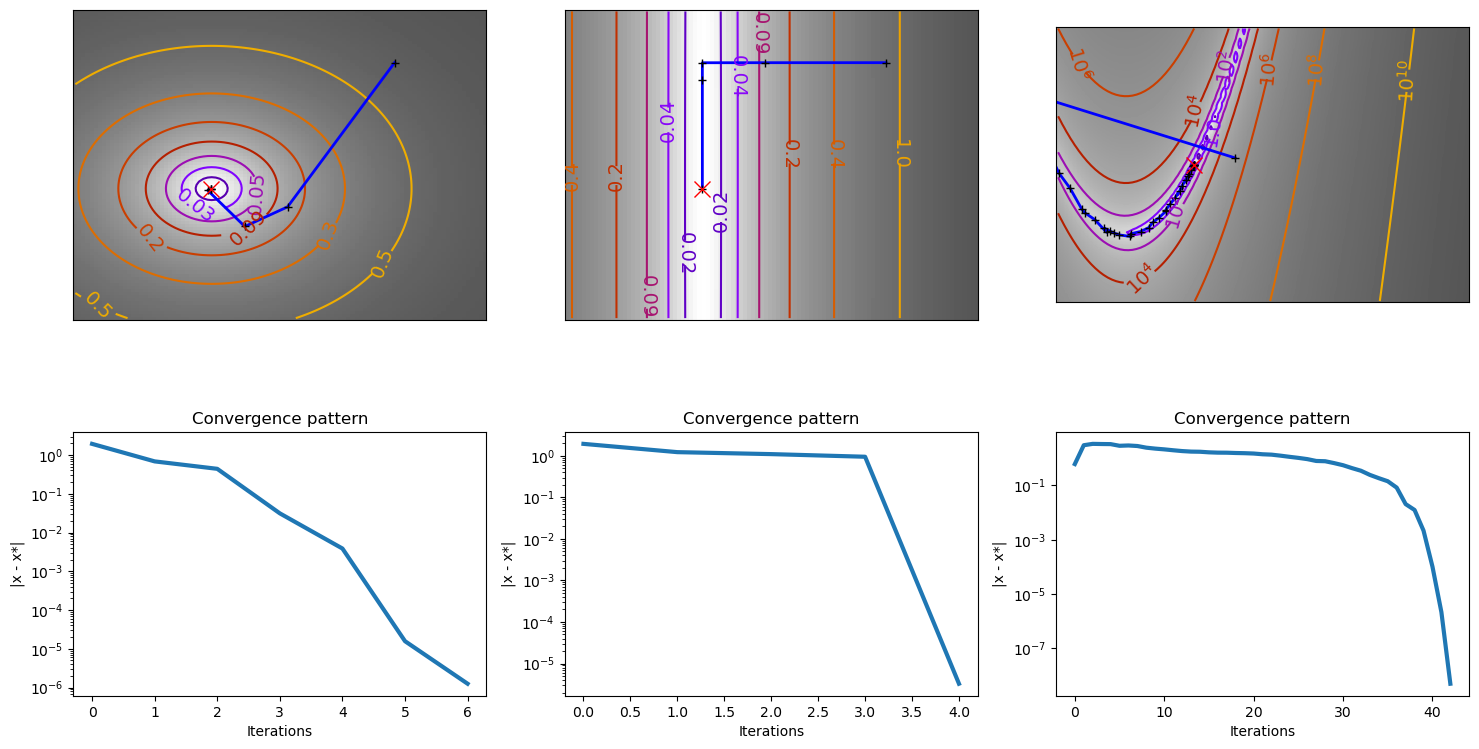

In [69]:
test_solver(bfgs)

**Anwser :**

1) When applied to the Gaussian kernel, this algorithm demonstrates superior convergence compared to its predecessors. This improvement suggests a more efficient approach in handling the complexities associated with this particular kernel.

2) In the case of the quadratic function, the BFGS algorithm shows a notable advancement. Although the convergence isn't as rapid as reaching it in just 2 iterations, it successfully does so in 4 iterations. This is a significant improvement over the earlier DFP method, primarily due to a more accurate approximation of the Hessian matrix involved in the computation.

3) The algorithm's effectiveness is further highlighted when dealing with the Rosenbrock function. Here, the BFGS algorithm achieves convergence twice as fast as the DFP algorithm, underscoring its efficiency in handling this type of function.

These improvements in the BFGS algorithm's performance it'sattributed to its ability to find a more optimal step size during the optimization process. This aspect of the algorithm plays a crucial role in enhancing its overall efficiency and effectiveness in various applications.

# Part 4: Implement L-BFGS algorithm


<div class="alert alert-success">
    <b>QUESTION 4:</b>
     <ul>
         <li>You should now implement the L-BFGS algorithm. We ask you to code the two-loops recursion in the function called two_loops.</li>
         <li>Comment briefly on what you see.</li>
    </ul>
</div>

**Remark:** The question is hard. Consider this as a bonus question.

In [90]:
def two_loops(grad_x, m, s_list, y_list, mu_list, B0):
    '''
    Parameters
    ----------
    grad_x : ndarray, shape (n,)
        gradient at the current point

    m : int
        memory size

    s_list : list of length m
        the past m values of s

    y_list : list of length m
        the past m values of y

    mu_list : list of length m
        the past m values of mu

    B0 : ndarray, shape (n, n)
        Initial inverse Hessian guess

    Returns
    -------
    r :  ndarray, shape (n,)
        the L-BFGS direction
    '''
    q = grad_x.copy()
    alpha_list = []

    memory_size = min(m, len(s_list), len(y_list), len(mu_list))

    # First loop : Correction Loop
    for i in range(memory_size):
        t = memory_size - i - 1
        alpha = 1 / np.dot(y_list[t].T, s_list[t])
        alpha_list.append(alpha * np.dot(s_list[t].T, q))
        q -= alpha_list[i] * y_list[t]

    search_direction = np.dot(B0, q)

    # Second loop : Update Loop
    for i in range(memory_size):
        t = memory_size - i - 1
        beta = 1 / np.dot(y_list[i].T, s_list[i])
        beta_value = beta * np.dot(y_list[i].T, search_direction)
        search_direction += s_list[i] * (alpha_list[t] - beta_value)

    return -search_direction


In [91]:
def lbfgs(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.9
    max_iter = 100
    m = 2

    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    B0 = np.eye(len(x))  # Hessian approximation

    grad_x = f_grad(x)

    y_list, s_list, mu_list = [], [], []
    for k in range(1, max_iter + 1):

        # Compute the search direction
        d = two_loops(grad_x, m, s_list, y_list, mu_list, B0)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)

        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        # Compute the new value of x
        s = step * d
        x += s
        y = new_grad - grad_x
        mu = 1 / np.dot(y, s)
        ##################################################################
        # Update the memory
        y_list.append(y.copy())
        s_list.append(s.copy())
        mu_list.append(mu)
        if len(y_list) > m:
            y_list.pop(0)
            s_list.pop(0)
            mu_list.pop(0)
        ##################################################################

        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break

        grad_x = new_grad

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1

Running solver on case 2

Running solver on case 3


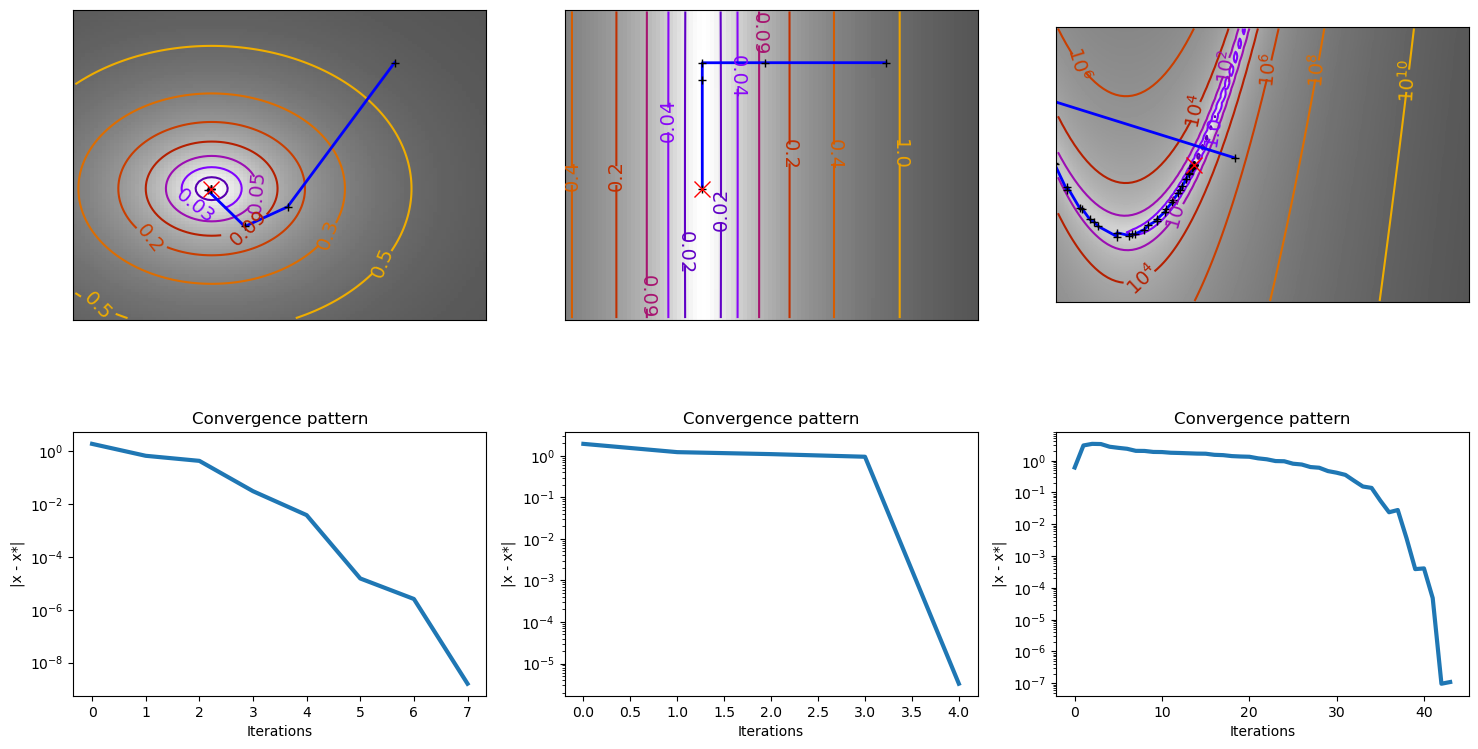

In [92]:
test_solver(lbfgs)

**Anwser :**

The L-BFGS algorithm displays performance characteristics that are broadly in line with those of the BFGS algorithm, though it shows a marginally weaker performance on both the Gaussian Kernel and the Rosenbrock function.

This minor disparity in performance could potentially stem from the nuances of its implementation, possibly attributable to human error. However, this aspect should not be overly emphasized in the analysis.

The primary aim of the L-BFGS algorithm is to match the convergence rate of the BFGS algorithm while optimizing its performance for computationally demanding optimization problems. This objective is achieved by deliberately limiting memory usage. By doing so, the algorithm enhances its performance by computing each step more efficiently, avoiding the need to process an excessive amount of data.